In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysam
import re

def get_bin(L, pos):
    return pos//(L/20)

error_count = {bin_number: {'I':0,'D':0,'Sub':0,'M':0} for bin_number in range(20)}


bamfile = pysam.AlignmentFile("/qbio/shjo/23-1_bioinformatics/expansion/aligned/35L33G.MD.tobam.bam", "rb")
for read in tqdm(bamfile.fetch(until_eof=True)):
    
    reference_seq = read.get_reference_sequence()
    pos_list = read.get_aligned_pairs()
    reference_start = read.reference_start
    
    S_num = 0   
    for op, length in read.cigartuples:
        if op == 4: S_num += length
        else: pass
      
    index = 0  
    for op, length in read.cigartuples: 
        if op == 0:  
            for i in range(index, length+index):
                read_pos, reference_pos = pos_list[i]
                if type(reference_pos) == type(None) or type(read_pos) == type(None): continue
                if reference_seq[reference_pos-reference_start] != read.query_sequence[read_pos]:
                    error_count[get_bin(len(reference_seq) + S_num, reference_pos-reference_start)]['Sub'] += 1
                else: 
                    error_count[get_bin(len(reference_seq) + S_num, reference_pos-reference_start)]['M'] += 1
            index += length   

        elif op == 1: 
            read_pos, reference_pos = pos_list[index-1] 
            if type(reference_pos) == type(None) or type(read_pos) == type(None): continue
            error_count[get_bin(len(reference_seq) + S_num, reference_pos-reference_start)]['I'] += length 
            index += length

        elif op == 2:  
            for i in range(index, length+index):
                _, reference_pos = pos_list[i]
                if type(reference_pos) == type(None): continue
                error_count[get_bin(len(reference_seq) + S_num, reference_pos-reference_start)]['D'] += 1
            index += length

        elif op == 4: 
            index += length    

        else: pass  
bamfile.close()

error_df = pd.DataFrame(error_count).T
error_df

11257800it [11:34, 16216.82it/s]


,I,D,Sub,M
0,0,0,45902,29122029
1,1,5,233675,23369794
2,96,2529,241177,24233589
3,193,13972,214069,23153662
4,1655,42401,232295,24542989
5,1802,73624,217879,22857537
6,1746,200044,240345,23989727
7,4838,172036,530415,21799018
8,1716,279709,633627,23332003
9,2555,173352,310817,21699044


In [2]:
error_df['pI'] = (error_df['I']/error_df.sum(axis=1))*100  
error_df['pD'] = (error_df['D']/error_df.sum(axis=1))*100
error_df['pSub'] = (error_df['Sub']/error_df.sum(axis=1))*100
error_df['pM'] = (error_df['M']/error_df.sum(axis=1))*100
error_df

,I,D,Sub,M,pI,pD,pSub,pM
0,0,0,45902,29122029,0.000000,0.000000,0.157371,99.842628
1,1,5,233675,23369794,0.000004,0.000021,0.990003,99.009968
2,96,2529,241177,24233589,0.000392,0.010332,0.985305,99.003967
3,193,13972,214069,23153662,0.000825,0.059756,0.915533,99.023882
4,1655,42401,232295,24542989,0.006668,0.170839,0.935943,98.886545
5,1802,73624,217879,22857537,0.007784,0.318019,0.941128,98.733064
6,1746,200044,240345,23989727,0.007146,0.818783,0.983736,98.190327
7,4838,172036,530415,21799018,0.021496,0.764390,2.356739,96.857361
8,1716,279709,633627,23332003,0.007077,1.153579,2.613212,96.226116
9,2555,173352,310817,21699044,0.011516,0.781366,1.400975,97.806133


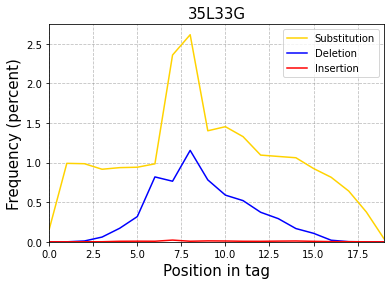

In [6]:
plt.plot(error_df['pSub'], label='Substitution', color='#FFD300')
plt.plot(error_df['pD'], label='Deletion', color='blue')
plt.plot(error_df['pI'], label='Insertion', color='red')

plt.title('35L33G', fontsize=15)
plt.grid(linestyle='--', color='grey', alpha=0.5)
plt.xlim(0,19)
plt.ylim(0,)

plt.xlabel('Position in tag', fontsize=15)
plt.ylabel('Frequency (percent)', fontsize=15)

plt.legend()
plt.show()

In [5]:
error_df.to_pickle('/qbio/shjo/23-1_bioinformatics/35L33G.error_df.pkl')